## Collect Map Data

### Setup and Connect

In [48]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

class RobotControl():
    # Initialize Function
    def __init__(self, ble):
        self.ble = ble
        self.notifiers_on = False
        self.TOF_HISTORY_LEN = 300
        self.IMU_HISTORY_LEN = 2400
        self.calibration_factor = 0

        # A variable to store the latest sensor value
        self.latest_tof_front_reading = None
        
        # A list to store the history of all the sensor values
        # Each item in the list is a tuple (value, time)
        # WARNING: The list could grow really fast; you need to deal with this accordingly.
        self.tof1_readings = [] # TODO change these to a bounded queue
        self.tof2_readings = []
        self.imu_readings = []
        self.bot_pid_debug = []
        self.imu_pitch_angles = []
        self.imu_roll_angles = []
        self.imu_times = []
        
        # A variable to store the latest imu reading
        self.latest_imu_reading = None
        
        # Activate notifications (if required)
        self.setup_notify()
    
    # A function to activate various notifications (if required)
    def setup_notify(self):
        # Code to setup various notify events
        # Ex:
        ble.start_notify(ble.uuid['RX_TOF1'], self.tof1_callback_handler)
        ble.start_notify(ble.uuid['RX_TOF2'], self.tof2_callback_handler)
        ble.start_notify(ble.uuid['RX_IMU'], self.imu_callback_handler)
        ble.start_notify(ble.uuid['RX_MOTOR_PID'], self.motor_pid_callback_handler)
        ble.start_notify(ble.uuid['RX_IMU_PITCH'], self.imu_pitch_callback_handler)
        ble.start_notify(ble.uuid['RX_IMU_ROLL'], self.imu_roll_callback_handler)
        ble.start_notify(ble.uuid['RX_IMU_TIMES'], self.imu_times_callback_handler)
        self.notifiers_on = True

    def stop_notify(self):
        ble.stop_notify(ble.uuid['RX_TOF1'])
        ble.stop_notify(ble.uuid['RX_TOF2'])
        ble.stop_notify(ble.uuid['RX_IMU'])
        ble.stop_notify(ble.uuid['RX_MOTOR_PID'])
        ble.stop_notify(ble.uuid['RX_IMU_PITCH'])
        ble.stop_notify(ble.uuid['RX_IMU_ROLL'])
        ble.stop_notify(ble.uuid['RX_IMU_TIMES'])
        self.notifiers_on = False
    
    def tof1_callback_handler(self, uuid, byte_array):
        self.tof1_readings.append( self.ble.bytearray_to_float(byte_array) )

    def tof2_callback_handler(self, uuid, byte_array):
        self.tof2_readings.append( ( self.ble.bytearray_to_float(byte_array), time.time() ) )
    
    def imu_callback_handler(self, uuid, byte_array):
        self.imu_readings.append( (self.ble.bytearray_to_string(byte_array), time.time()) )

    def motor_pid_callback_handler(self, uuid, byte_array):
        self.bot_pid_debug.append( self.ble.bytearray_to_float(byte_array) )

    def imu_pitch_callback_handler(self, uuid, byte_array):
        self.imu_pitch_angles.append( self.ble.bytearray_to_float(byte_array) )

    def imu_roll_callback_handler(self, uuid, byte_array):
        self.imu_roll_angles.append( self.ble.bytearray_to_float(byte_array) )
    
    def imu_times_callback_handler(self, uuid, byte_array):
        self.imu_times.append( self.ble.bytearray_to_float(byte_array) )

    def clear_history(self):
        self.tof1_readings = [] # TODO change these to a bounded queue
        self.tof2_readings = []
        self.imu_readings = []
        self.bot_pid_debug = []
        self.imu_pitch_angles = []
        self.imu_roll_angles = []
        self.imu_times = []

    def get_front_tof(self):
        ble.send_command(CMD.GET_FRONT_TOF, None)
        return self.tof1_readings[-1]

    
    # An example function to fetch the IMU readings as a string
    # Here we assume RX_IMU is a valid UUID defined in connection.yaml and
    # in the Arduino code as wellt
    # def get_imu(self):
    #     self.latest_imu_reading = self.ble.receive_string(self.ble.uuid['RX_IMU'])
    #     pass
    
    def start_pid(self, p_const, setpoint, min_power=100, imu_hz=55):
        ble.send_command(CMD.START_PID, f"{p_const}|{setpoint}|{min_power}|{imu_hz}")

    def stop_pid(self):
        ble.send_command(CMD.STOP_PID, None)

    # A function to instruct the robot to move forward
    def move_forward(self, speed):
        ble.send_command(CMD.MOVE_FORWARD, speed)
    
    def move_backward(self, speed):
        ble.send_command(CMD.MOVE_BACKWARD, speed)

    def set_motor_calibration(self, new_val):
        ble.send_command(CMD.SET_MOTOR_CALIB, new_val)
        self.calibration_factor = new_val
    
    # A function to stop robot motion
    def stop(self):
        ble.send_command(CMD.STOP, None)

    def start_data_collection(self):
        ble.send_command(CMD.START_DATA_COLLECTION, None)
    
    def stop_data_collection(self, get_tof=True, get_imu=False, get_pid=False):
        temp_notif = self.notifiers_on
        if not temp_notif:
            self.setup_notify()
        ble.send_command(CMD.STOP_DATA_COLLECTION, None)
        if get_tof:
            self.get_tof_data()
        if get_imu:
            self.get_imu_data()
        if get_pid:
            self.get_pid_data()
        
    def get_tof_data(self):
        if not self.notifiers_on:
            self.setup_notify()
        for i in range(self.TOF_HISTORY_LEN):
            ble.send_command(CMD.GET_TOF1_DATA, i)
            
    
    def get_imu_data(self):
        if not self.notifiers_on:
            self.setup_notify()
        for i in range(self.TOF_HISTORY_LEN):
            # 1 for Pitch only, 2 for float only, 3 for all, 4 for keyframes only
            ble.send_command(CMD.GET_IMU_DATA, f"{i}|{4}")
    
    def get_pid_data(self):
        if not self.notifiers_on:
            self.setup_notify()
        len = self.IMU_HISTORY_LEN
        for i in range(len):
            ble.send_command(CMD.GET_PID_DATA, i)
        
    """
    Step response, but hard break at step_stop
    """
    def start_step_response(self, step_stop):
        ble.send_command(CMD.START_STEP_RESPONSE, step_stop)
    
    def stop_step_response(self):
        ble.send_command(CMD.STOP_STEP_RESPONSE, None)

    def do_stunt(self, stunt_setpoint, stunt_pid_proportional):
        ble.send_command(CMD.START_STUNT, f"{stunt_setpoint}|{stunt_pid_proportional}")

    def sudden_flip(self, raw_power, scale=False):
        if scale:
            ble.send_command(CMD.SUDDEN_FLIP, raw_power * 255 / self.calibration_factor)
        else:
            ble.send_command(CMD.SUDDEN_FLIP, raw_power)

    def spin(self, a, b):
        # Spins A and B
        ble.send_command(CMD.SPIN, f"{a}|{b}")

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define Robot Controller Class

In [50]:
LOG.propagate = False
ble = get_ble_controller()
ble.connect()
time.sleep(5)
bot = RobotControl(ble)

2022-04-01 17:25:10,758 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:07:21:8D:B3:44
2022-04-01 17:25:14,001 | INFO     |: Connected to C0:07:21:8D:B3:44


### Run Stunt

In [58]:
def test_spin(power, duration):
  # My room floor: MIN 90-ish MAX 160
  bot.clear_history()
  calib = 1.6
  bot.set_motor_calibration(calib)
  # Deadband of about 90?
  bot.spin(-1*power,power*calib)
  time.sleep(duration)
  # bot.spin(power, -1*power*calib)
  # time.sleep(duration)
  bot.stop()

def do_pid():
  bot.clear_history()
  bot.set_motor_calibration(1.6)
  bot.start_data_collection()
  bot.start_pid(1, 20, min_power=80, imu_hz=40) # old imu_hz = 100
  time.sleep(35)
  bot.stop_pid()
  bot.stop()
  bot.stop_data_collection(get_tof=True, get_imu=True, get_pid=True)

#test_spin(80, 5)
do_pid()

### Process and Plot

145
[80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80.0, 0.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 0.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, -80.0, -80.0, -80.0, -80.0, 0.0, 80.0]
[0.0, 0.094, 0.192, 0.646, 0.745, 0.842, 1.477, 1.579, 1.678, 2.241, 2.329, 2.429, 3.066, 3.157, 3.26, 3.881, 3.97, 4.069, 4.66, 4.752, 4.85, 5.472, 5.57, 5.672, 6.327, 6.425, 6.523, 7.098, 7.191, 7.289, 8.065, 8.168, 8.262, 8.768, 8.866, 8.965, 9.529, 9.622, 9.721, 10.325, 10.413, 10.516, 10.89, 10.982, 11.084, 11.551, 11.64, 11.743, 12.124, 12.217, 12.317, 12.964, 13.057, 13.16, 13.497, 13.59, 13.693, 14.129, 14.219, 14.319, 14.761, 14.854, 14.957, 15.379, 15.473, 15.572, 16.208, 16.301, 16.403, 16.909, 16.999, 17.096, 17.634]
Pitch: [19.

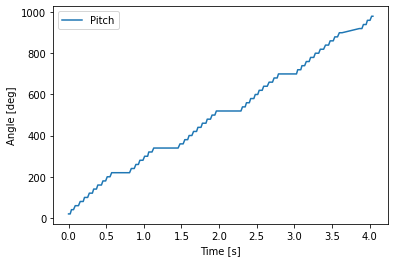

In [59]:
# Round off for readability
# bot.get_imu_data()
pitch_angles = [round(x,2) for x in bot.imu_pitch_angles]
roll_angles = [round(x,2) for x in bot.imu_roll_angles]
bot_times = [(x - bot.imu_times[0]) / 1000 for x in bot.imu_times]
pid_raw = bot.bot_pid_debug
pid_power = []
pid_times = []

# Find "last" data point
last_data_point = 0
for i in reversed(range(len(pitch_angles))):
  if i % 2 == 0: continue
  if pitch_angles[i] == 0: continue
  last_data_point = i
  break
print(last_data_point)

# trim
pitch_angles = pitch_angles[:1+last_data_point]
roll_angles = roll_angles[:1+last_data_point]
pitch_angles = pitch_angles[:1+last_data_point]
bot_times = bot_times[:1+last_data_point]
pid_raw = pid_raw[:1+last_data_point]

# print(pid_raw)


for i, x in enumerate(pid_raw):
  if i % 2 == 0:
    pid_power.append(x)
  else:
    pid_times.append(x)
pid_times = [(x - pid_times[0]) / 1000 for x in pid_times]

print(pid_power)
print(pid_times)

# Print for sanity check
print(f"Pitch: {pitch_angles}")
print(f"Roll: {roll_angles}")
print(f"Times: {bot_times}")

# Filter TOF readings and trim
tof_dist = []
for i in range(len(bot.tof1_readings)):
  if i % 2 == 0:
    tof_dist.append(bot.tof1_readings[i])

last_data_point = 0
for i in reversed(range(len(tof_dist))):
  if i % 2 == 0: continue
  if tof_dist[i] == 0: continue
  last_data_point = i
  break
tof_dist = tof_dist[:1+last_data_point]

plt.plot(bot_times, pitch_angles, label="Pitch") # Reads at about 120 Hz?
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.legend()



[1747.0, 1310.0, 1313.0, 1461.0, 1434.0, 1445.0, 1640.0, 1732.0, 1639.0, 1678.0, 751.0, 743.0, 742.0, 679.0, 678.0, 677.0, 665.0, 665.0, 1762.0, 1697.0, 1758.0, 1381.0, 1375.0, 1389.0, 1406.0, 1393.0, 1387.0, 1281.0, 1276.0, 1287.0, 880.0, 875.0, 876.0, 1333.0, 1341.0, 1342.0, 1341.0, 1578.0, 1575.0, 1564.0, 1823.0, 1814.0, 1833.0, 1632.0, 1622.0, 1620.0, 1520.0, 1517.0, 1475.0, 764.0, 760.0, 760.0, 930.0, 927.0, 940.0, 1318.0, 1320.0, 1354.0, 1356.0, 1356.0, 1360.0, 1319.0, 1329.0, 1377.0, 1375.0, 1386.0, 1378.0, 1563.0, 1565.0, 1557.0, 820.0, 808.0, 707.0, 705.0, 709.0, 705.0, 665.0, 666.0, 671.0, 1719.0, 1750.0, 1674.0, 1594.0, 1578.0, 1542.0, 1400.0, 1382.0, 1268.0, 1246.0, 1278.0, 1067.0, 1069.0, 1076.0, 804.0, 805.0, 804.0, 807.0, 1286.0, 1291.0, 1296.0, 1493.0, 1494.0, 1474.0, 1696.0, 1698.0, 1587.0, 1589.0, 1581.0, 1545.0, 1543.0, 1547.0, 1516.0, 771.0, 774.0, 864.0, 859.0, 862.0, 1030.0, 1033.0, 1038.0, 1426.0, 1442.0, 1449.0, 1445.0, 1406.0, 1395.0, 1399.0, 1416.0, 1404.0, 14

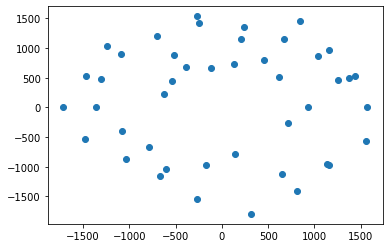

In [60]:
print(tof_dist)
tof_points = []
temp_meas = []
for i, x in enumerate(tof_dist):
  temp_meas.append(x)
  if (i != 0 and i % 3 == 0) or i == len(tof_dist) - 1:
    tof_points.append((sum(temp_meas)/len(temp_meas), 20*((i+1)//3)*np.pi/180 ))
    temp_meas = []

print(tof_points)
tof_points_cart = []
for (r,theta) in tof_points:
  tof_points_cart.append((r*np.cos(theta), r*np.sin(theta)))

tof_polar_x = [x[0] for x in tof_points_cart]
tof_polar_y = [x[1] for x in tof_points_cart]

plt.scatter(tof_polar_x, tof_polar_y)
  

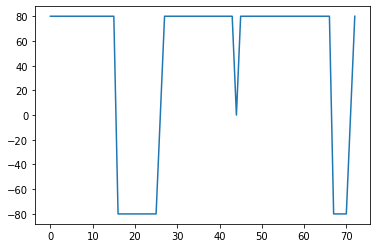

In [61]:
# print(bot.tof1_readings)
# print(bot.tof2_readings)
# print(bot.imu_readings)
# print(bot.bot_pid_debug)
# print(bot.imu_pitch_angles)
# print(bot.imu_roll_angles)
# print(bot.imu_times)

plt.plot(pid_power)

